## Task 1



In [0]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, backend, optimizers
from sklearn.preprocessing import normalize
%matplotlib inline

In [2]:
!wget -O histos_tba https://uc048d8634003087e17e3217c3df.dl.dropboxusercontent.com/cd/0/get/A06Q7_nXRHXxTWN5zyRRGgXzeQH5yclMLR8eudDViil8eeZ9OFgLWkrL1ihDOaqoj5NbmUvhN6n4Km3quXj-VnXjUaqJoVq37tFQNwLZG2U-MW7YccMi6AuHueL8w_qZtek/file?_download_id=318993953814009406251755409166071366448415630657840514387678025865&_notify_domain=www.dropbox.com&dl=1

--2020-03-30 13:31:07--  https://uc048d8634003087e17e3217c3df.dl.dropboxusercontent.com/cd/0/get/A06Q7_nXRHXxTWN5zyRRGgXzeQH5yclMLR8eudDViil8eeZ9OFgLWkrL1ihDOaqoj5NbmUvhN6n4Km3quXj-VnXjUaqJoVq37tFQNwLZG2U-MW7YccMi6AuHueL8w_qZtek/file?_download_id=318993953814009406251755409166071366448415630657840514387678025865
Resolving uc048d8634003087e17e3217c3df.dl.dropboxusercontent.com (uc048d8634003087e17e3217c3df.dl.dropboxusercontent.com)... 162.125.9.6, 2620:100:601f:6::a27d:906
Connecting to uc048d8634003087e17e3217c3df.dl.dropboxusercontent.com (uc048d8634003087e17e3217c3df.dl.dropboxusercontent.com)|162.125.9.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 223440772 (213M) [application/binary]
Saving to: ‘histos_tba’

histos_tba          100%[===================>] 213.09M  32.9MB/s    in 7.0s    

2020-03-30 13:31:14 (30.5 MB/s) - ‘histos_tba’ saved [223440772/223440772]



In [0]:
with np.load('histos_tba') as data:
    variables = data['variables']
    parameters = data['parameters'] 

**Pre-processing data**

In [4]:
print(variables.shape)
print(parameters.shape)
del_ind = []
for i in range(7):
    for j in range(12*i+5, 12*i+12):
        del_ind.append(j)
# print(del_ind)
csc_var = np.delete(variables, del_ind, axis=1)
print(csc_var.shape)
l = csc_var.shape[1]*0.5
del_ind = []
for i in range(csc_var.shape[0]):
    count = 0
    for j in range(csc_var.shape[1]):
        if csc_var[i][j] == 0 or np.isnan(csc_var[i][j]):
            count += 1
    if count > l:
        del_ind.append(i)
    if i%100000 == 0:
        print("Checked",i, "samples")
var = np.delete(csc_var, del_ind, axis=0)
print(var.shape, len(del_ind))
avg = np.nanmean(var, axis=0)
for i in range(var.shape[1]):
    var[:,i] = np.nan_to_num(var[:,i], nan=avg[i])


(3272341, 87)
(3272341, 3)
(3272341, 38)
Checked 0 samples
Checked 100000 samples
Checked 200000 samples
Checked 300000 samples
Checked 400000 samples
Checked 500000 samples
Checked 600000 samples
Checked 700000 samples
Checked 800000 samples
Checked 900000 samples
Checked 1000000 samples
Checked 1100000 samples
Checked 1200000 samples
Checked 1300000 samples
Checked 1400000 samples
Checked 1500000 samples
Checked 1600000 samples
Checked 1700000 samples
Checked 1800000 samples
Checked 1900000 samples
Checked 2000000 samples
Checked 2100000 samples
Checked 2200000 samples
Checked 2300000 samples
Checked 2400000 samples
Checked 2500000 samples
Checked 2600000 samples
Checked 2700000 samples
Checked 2800000 samples
Checked 2900000 samples
Checked 3000000 samples
Checked 3100000 samples
Checked 3200000 samples
(1191431, 38) 2080910


**Data split**

In [13]:
var = normalize(var, axis=0)
a = np.arange(var.shape[0])
np.random.shuffle(a)
index = a[:int(var.shape[0]*0.7)]
train_data = var[index]
par = np.delete(parameters, del_ind, axis=0)
print(par.shape[0])
label = par[index,0]
im_label = par[index]
temp = normalize(im_label[:,[1,2]], axis=0)
im_label[:,[1,2]] = temp
# momentum = abs(1/label)
momentum = abs(label)
im_momentum = im_label
im_momentum[:,0] = abs(im_momentum[:,0])
print(np.min(momentum), np.max(momentum))
print(np.min(im_momentum[:,0]), np.max(im_momentum[:,0]))

t_ind = a[int(var.shape[0]*0.7):]
test_data = var[t_ind]
# test_data = normalize(test_data, axis=0)
t_mom = par[t_ind, 0]

1191431
0.00014307493 0.49999535
0.00014307493 0.49999535


In [0]:
avg = np.nanmean(csc_var, axis=0)
# print(avg)
for i in range(csc_var.shape[1]):
    csc_var[:,i] = np.nan_to_num(csc_var[:,i], nan=avg[i])

csc_var = normalize(csc_var, axis=0)
csc_var = np.delete(csc_var, index, axis=0)
# print(np.min(abs(t_mom)), np.max(t_mom))

**Function definitions**

In [0]:
def mse_error(pred):
  error = np.sum((abs(1/parameters[:,0]) - pred)**2)
  return error**0.5

In [0]:
def plot_loss(hist):
  plt.plot(hist.history['loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.show()

In [0]:
def gen_cluster(out):
    cluster = [[] for i in range(4)]
    label = []
    for i in range(out.shape[0]):
        if out[i] <= 10:
            cluster[0].append(i)
            label.append(0)
        elif out[i] <= 30:
            cluster[1].append(i)
            label.append(1)
        elif out[i] <= 100:
            cluster[2].append(i)
            label.append(2)
        else:
            cluster[3].append(i)
            label.append(3)
    return cluster, label


In [0]:
def gen_conf_mat(ori_label, pred_label):
  conf_mat = np.zeros([4,4])
  for i in range(len(ori_label)):
    conf_mat[ori_label[i]][pred_label[i]] += 1
  return conf_mat

In [0]:
def find_accuarcy(conf_mat):
  count = 0
  for i in range(4):
    count += conf_mat[i][i]
  return 100*(count/len(csc_var))

**FC Model**

In [20]:
predictor = tf.keras.Sequential()
predictor.add(layers.Dense(32, activation='relu', input_dim=train_data.shape[1]))
predictor.add(layers.Dropout(0.2))
predictor.add(layers.Dense(128, activation='relu'))
predictor.add(layers.Dropout(0.2))
predictor.add(layers.Dense(256, activation='relu'))
predictor.add(layers.Dropout(0.2))
predictor.add(layers.Dense(512, activation='relu'))
predictor.add(layers.Dropout(0.2))
predictor.add(layers.Dense(1024, activation='relu' ))
predictor.add(layers.Dropout(0.2))
predictor.add(layers.Dense(512, activation='relu'))
predictor.add(layers.Dropout(0.2))
predictor.add(layers.Dense(256, activation='relu'))
predictor.add(layers.Dropout(0.2))
predictor.add(layers.Dense(128, activation='relu'))
predictor.add(layers.Dropout(0.2))
predictor.add(layers.Dense(32, activation='relu'))
predictor.add(layers.Dense(1, activation='relu'))
print(predictor.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 32)                1248      
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               4224      
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)              

**Training Model**

In [21]:
predictor.compile(optimizer=optimizers.Adam(learning_rate=0.00004), loss='mse', metrics=['mae'])
hist1 = predictor.fit(train_data, momentum, batch_size=1024, epochs=50)
predictor.evaluate(test_data, t_mom, batch_size=1000)

Epoch 1/50
815/815 [==============================] - 9s 11ms/step - loss: 0.0156 - mae: 0.1019
Epoch 2/50
815/815 [==============================] - 9s 11ms/step - loss: 0.0099 - mae: 0.0790
Epoch 3/50
815/815 [==============================] - 9s 10ms/step - loss: 0.0077 - mae: 0.0679
Epoch 4/50
815/815 [==============================] - 8s 10ms/step - loss: 0.0063 - mae: 0.0610
Epoch 5/50
815/815 [==============================] - 9s 10ms/step - loss: 0.0057 - mae: 0.0572
Epoch 6/50
815/815 [==============================] - 9s 10ms/step - loss: 0.0052 - mae: 0.0545
Epoch 7/50
815/815 [==============================] - 9s 11ms/step - loss: 0.0049 - mae: 0.0524
Epoch 8/50
815/815 [==============================] - 9s 11ms/step - loss: 0.0046 - mae: 0.0508
Epoch 9/50
815/815 [==============================] - 9s 11ms/step - loss: 0.0044 - mae: 0.0494
Epoch 10/50
815/815 [==============================] - 9s 11ms/step - loss: 0.0042 - mae: 0.0482
Epoch 11/50
815/815 [==================

[0.09722501784563065, 0.21266572177410126]

**Loss plot**

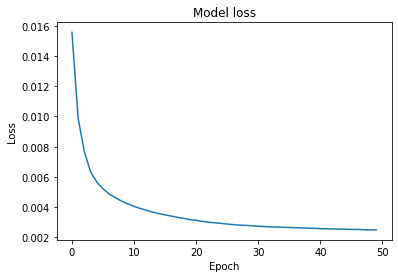

In [33]:
predictor.save('predictor.h5')
plot_loss(hist1)

**Predicting values**

In [41]:
# predictor = tf.keras.models.load_model('predictor.h5')
predictor.evaluate(test_data, t_mom, batch_size=8196)
out1 = 1/predictor.predict(csc_var)
print(np.max(out1), np.min(out1))

44/44 [==============================] - 1s 17ms/step - loss: 0.0972 - mae: 0.2127
17.904488 2.3839595


**Predicted cluster**

In [0]:
mom = abs(1/parameters[:,0])
mom = np.delete(mom, index, axis=0)
ori_cluster, ori_label = gen_cluster(mom)
pred_cluster, pred_label = gen_cluster(out1)

In [46]:
print(len(ori_cluster[0]), len(ori_cluster[1]), len(ori_cluster[2]), len(ori_cluster[3]))
print(len(pred_cluster[0]), len(pred_cluster[1]), len(pred_cluster[2]), len(pred_cluster[3]))

1882273 371016 129985 55066
2183508 254832 0 0


**Performance of model**

In [47]:
conf_mat1 = gen_conf_mat(ori_label, pred_label)
print(conf_mat1)
print("Accuracy of model =", find_accuarcy(conf_mat1))

[[1644224.  238049.       0.       0.]
 [ 359340.   11676.       0.       0.]
 [ 126549.    3436.       0.       0.]
 [  53395.    1671.       0.       0.]]
Accuracy of model = 67.91095581420147


**CNN Model**

In [34]:
def gen_3d_data(data):
    zero_col = np.zeros(data.shape[0])
    temp_data = np.insert(data, data.shape[1], zero_col, axis=1)
    temp_data = np.insert(temp_data, temp_data.shape[1], zero_col, axis=1)
    # conv_data = np.reshape(conv_data, (conv_data.shape[0], 5, 8))
    conv_data = np.zeros([data.shape[0], 5, 8])
    for i in range(5):
        for j in range(8):
            conv_data[:,i,j] = temp_data[:,5*j+i]
    return conv_data

conv_data = gen_3d_data(var)
nr, nf = conv_data.shape[1], conv_data.shape[2]
print(nr, nf)

5 8


In [66]:
conv_model = tf.keras.Sequential()
conv_model.add(layers.Conv1D(filters=32, kernel_size=8, padding='same',activation='relu', input_shape=(nr, nf)))
# conv_model.add(layers.Dropout(0.3))
conv_model.add(layers.Conv1D(filters=32, kernel_size=8, padding='same', activation='relu'))
# conv_model.add(layers.Dropout(0.3))
conv_model.add(layers.Conv1D(filters=16, kernel_size=8, padding='same', activation='relu'))
conv_model.add(layers.MaxPooling1D(pool_size=3))
conv_model.add(layers.Flatten())
conv_model.add(layers.Dense(32, activation='relu'))
conv_model.add(layers.Dense(128, activation='relu'))
conv_model.add(layers.Dropout(0.3))
conv_model.add(layers.Dense(256, activation='relu'))
conv_model.add(layers.Dropout(0.3))
conv_model.add(layers.Dense(512, activation='relu'))
conv_model.add(layers.Dropout(0.3))
conv_model.add(layers.Dense(1024, activation='relu'))
conv_model.add(layers.Dropout(0.3))
conv_model.add(layers.Dense(512, activation='relu'))
conv_model.add(layers.Dropout(0.3))
conv_model.add(layers.Dense(256, activation='relu'))
conv_model.add(layers.Dropout(0.3))
conv_model.add(layers.Dense(128, activation='relu'))
conv_model.add(layers.Dropout(0.3))
conv_model.add(layers.Dense(32, activation='relu'))
conv_model.add(layers.Dense(1))

print(conv_model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 5, 32)             2080      
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 5, 32)             8224      
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 5, 16)             4112      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 1, 16)             0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_60 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_61 (Dense)             (None, 128)              

**Training Model**

In [67]:
conv_train = conv_data[index]
conv_model.compile(optimizer=optimizers.Adam(0.00002), loss='mse', metrics=['mae'])
hist2 = conv_model.fit(conv_train, momentum, batch_size=1024, epochs=50)

Epoch 1/50
815/815 [==============================] - 11s 14ms/step - loss: 0.0189 - mae: 0.1123
Epoch 2/50
815/815 [==============================] - 11s 14ms/step - loss: 0.0093 - mae: 0.0765
Epoch 3/50
815/815 [==============================] - 11s 14ms/step - loss: 0.0051 - mae: 0.0540
Epoch 4/50
815/815 [==============================] - 11s 14ms/step - loss: 0.0043 - mae: 0.0485
Epoch 5/50
815/815 [==============================] - 11s 13ms/step - loss: 0.0040 - mae: 0.0464
Epoch 6/50
815/815 [==============================] - 11s 13ms/step - loss: 0.0038 - mae: 0.0450
Epoch 7/50
815/815 [==============================] - 11s 14ms/step - loss: 0.0036 - mae: 0.0440
Epoch 8/50
815/815 [==============================] - 11s 14ms/step - loss: 0.0034 - mae: 0.0428
Epoch 9/50
815/815 [==============================] - 11s 13ms/step - loss: 0.0033 - mae: 0.0423
Epoch 10/50
815/815 [==============================] - 11s 14ms/step - loss: 0.0031 - mae: 0.0416
Epoch 11/50
815/815 [========

**Loss plot**

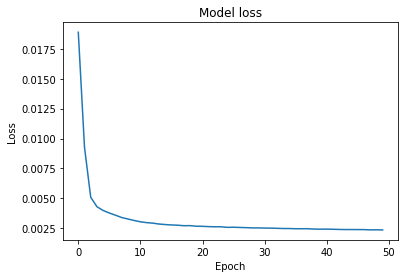

In [71]:
conv_model.save('conv_model.h5')
plot_loss(hist2)

In [68]:
conv_full_data = gen_3d_data(csc_var)
out2 = conv_model.predict(conv_full_data)
print(np.max(out2), np.min(out2))

0.42078233 0.048125222


**Predicted clusters**

In [69]:
conv_pred, conv_label = gen_cluster(out2)
print(len(ori_cluster[0]), len(ori_cluster[1]), len(ori_cluster[2]), len(ori_cluster[3]))
print(len(conv_pred[0]), len(conv_pred[1]), len(conv_pred[2]), len(conv_pred[3]))

1882273 371016 129985 55066
2438340 0 0 0


**Model Performance**

In [70]:
conf_mat2 = gen_conf_mat(ori_label, conv_label)
print(conf_mat2)
print("Accuracy of model =", find_accuarcy(conf_mat2))

[[1882273.       0.       0.       0.]
 [ 371016.       0.       0.       0.]
 [ 129985.       0.       0.       0.]
 [  55066.       0.       0.       0.]]
Accuracy of model = 77.19485387599761


## Task 2

**FC Model**

In [38]:
img_predictor = tf.keras.Sequential()
img_predictor.add(layers.Dense(32, activation='relu', input_dim=train_data.shape[1]))
# predictor.add(layers.Dropout(0.1))
img_predictor.add(layers.Dense(128, activation='relu'))
img_predictor.add(layers.Dropout(0.2))
img_predictor.add(layers.Dense(256, activation='relu'))
img_predictor.add(layers.Dropout(0.2))
img_predictor.add(layers.Dense(512, activation='relu'))
img_predictor.add(layers.Dropout(0.2))
img_predictor.add(layers.Dense(1024, activation='relu' ))
img_predictor.add(layers.Dropout(0.2))
img_predictor.add(layers.Dense(512, activation='relu'))
img_predictor.add(layers.Dropout(0.2))
img_predictor.add(layers.Dense(256, activation='relu'))
img_predictor.add(layers.Dropout(0.2))
img_predictor.add(layers.Dense(128, activation='relu'))
img_predictor.add(layers.Dropout(0.2))
img_predictor.add(layers.Dense(32, activation='relu'))
# predictor.add(layers.Dropout(0.1))
img_predictor.add(layers.Dense(3))
print(img_predictor.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 32)                1248      
_________________________________________________________________
dense_31 (Dense)             (None, 128)               4224      
_________________________________________________________________
dropout_23 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_24 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_25 (Dropout)         (None, 512)              

**Training Model**

In [39]:
img_predictor.compile(optimizer=optimizers.Adam(learning_rate=0.00002), loss='mse', metrics=['mae'])
hist3 = img_predictor.fit(train_data, im_momentum, batch_size=1024, epochs=50)

Epoch 1/50
815/815 [==============================] - 9s 11ms/step - loss: 0.0063 - mae: 0.0433
Epoch 2/50
815/815 [==============================] - 9s 11ms/step - loss: 0.0038 - mae: 0.0326
Epoch 3/50
815/815 [==============================] - 9s 11ms/step - loss: 0.0026 - mae: 0.0257
Epoch 4/50
815/815 [==============================] - 9s 11ms/step - loss: 0.0019 - mae: 0.0216
Epoch 5/50
815/815 [==============================] - 9s 11ms/step - loss: 0.0017 - mae: 0.0197
Epoch 6/50
815/815 [==============================] - 9s 11ms/step - loss: 0.0015 - mae: 0.0186
Epoch 7/50
815/815 [==============================] - 9s 11ms/step - loss: 0.0014 - mae: 0.0179
Epoch 8/50
815/815 [==============================] - 9s 11ms/step - loss: 0.0014 - mae: 0.0172
Epoch 9/50
815/815 [==============================] - 9s 11ms/step - loss: 0.0013 - mae: 0.0168
Epoch 10/50
815/815 [==============================] - 9s 11ms/step - loss: 0.0013 - mae: 0.0163
Epoch 11/50
815/815 [==================

**Loss plot**

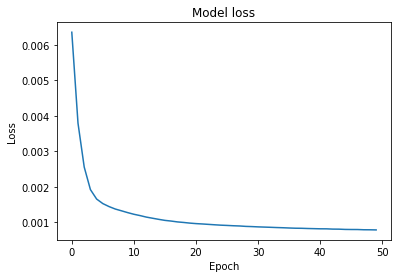

In [40]:
img_predictor.save('img_predictor.h5')
plot_loss(hist3)

In [51]:
# img_predictor = tf.keras.models.load_model('img_predictor.h5')
img_predictor.evaluate(test_data, t_mom, batch_size=8196)
out3 = img_predictor.predict(csc_var)
out3[:,0] = abs(1/out3[:,0])
print(np.max(out3[:,0]), np.min(out3[:,0]))

44/44 [==============================] - 1s 17ms/step - loss: 0.0727 - mae: 0.2084
21.823713 2.289417


**Predicted cluster**

In [52]:
im_pred_cluster, im_pred_label = gen_cluster(out3[:,0])
print(len(ori_cluster[0]), len(ori_cluster[1]), len(ori_cluster[2]), len(ori_cluster[3]))
print(len(im_pred_cluster[0]), len(im_pred_cluster[1]), len(im_pred_cluster[2]), len(im_pred_cluster[3]))

1882273 371016 129985 55066
2277925 160415 0 0


**Performance of model**

In [61]:
conf_mat3 = gen_conf_mat(ori_label, im_pred_label)
print(conf_mat3)
print("Accuracy of model =", find_accuarcy(conf_mat3))

[[2.397418e+06 1.288640e+05 0.000000e+00 0.000000e+00]
 [4.937660e+05 3.890000e+03 0.000000e+00 0.000000e+00]
 [1.728100e+05 1.667000e+03 0.000000e+00 0.000000e+00]
 [7.302500e+04 9.010000e+02 0.000000e+00 0.000000e+00]]
Accuracy of model = 73.38196110979877


**CNN Model**

In [73]:
im_conv_model = tf.keras.Sequential()
im_conv_model.add(layers.Conv1D(filters=32, kernel_size=8, padding='same',activation='relu', input_shape=(nr, nf)))
# conv_model.add(layers.Dropout(0.3))
im_conv_model.add(layers.Conv1D(filters=32, kernel_size=8, padding='same', activation='relu'))
# conv_model.add(layers.Dropout(0.3))
im_conv_model.add(layers.Conv1D(filters=16, kernel_size=8, padding='same', activation='relu'))
im_conv_model.add(layers.MaxPooling1D(pool_size=3))
im_conv_model.add(layers.Flatten())
im_conv_model.add(layers.Dense(32, activation='relu'))
im_conv_model.add(layers.Dense(128, activation='relu'))
im_conv_model.add(layers.Dropout(0.3))
im_conv_model.add(layers.Dense(256, activation='relu'))
im_conv_model.add(layers.Dropout(0.3))
im_conv_model.add(layers.Dense(512, activation='relu'))
im_conv_model.add(layers.Dropout(0.3))
im_conv_model.add(layers.Dense(1024, activation='relu'))
im_conv_model.add(layers.Dropout(0.3))
im_conv_model.add(layers.Dense(512, activation='relu'))
im_conv_model.add(layers.Dropout(0.3))
im_conv_model.add(layers.Dense(256, activation='relu'))
im_conv_model.add(layers.Dropout(0.3))
im_conv_model.add(layers.Dense(128, activation='relu'))
im_conv_model.add(layers.Dropout(0.3))
im_conv_model.add(layers.Dense(32, activation='relu'))
im_conv_model.add(layers.Dense(3))

print(im_conv_model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 5, 32)             2080      
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 5, 32)             8224      
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 5, 16)             4112      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 1, 16)             0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_70 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_71 (Dense)             (None, 128)              

**Training model**

In [74]:
im_conv_train = conv_data[index]
t_im = np.copy(im_momentum)
# t_im[:,0] = 100*t_im[:,0] 
im_conv_model.compile(optimizer=optimizers.Adam(0.00002), loss='mse', metrics=['mae'])
hist4 = im_conv_model.fit(conv_train, t_im, batch_size=1024, epochs=50)

Epoch 1/50
815/815 [==============================] - 11s 14ms/step - loss: 0.0063 - mae: 0.0439
Epoch 2/50
815/815 [==============================] - 11s 14ms/step - loss: 0.0045 - mae: 0.0365
Epoch 3/50
815/815 [==============================] - 11s 14ms/step - loss: 0.0024 - mae: 0.0255
Epoch 4/50
815/815 [==============================] - 11s 14ms/step - loss: 0.0017 - mae: 0.0207
Epoch 5/50
815/815 [==============================] - 11s 14ms/step - loss: 0.0015 - mae: 0.0190
Epoch 6/50
815/815 [==============================] - 11s 14ms/step - loss: 0.0014 - mae: 0.0180
Epoch 7/50
815/815 [==============================] - 11s 14ms/step - loss: 0.0013 - mae: 0.0174
Epoch 8/50
815/815 [==============================] - 11s 14ms/step - loss: 0.0013 - mae: 0.0168
Epoch 9/50
815/815 [==============================] - 11s 14ms/step - loss: 0.0012 - mae: 0.0164
Epoch 10/50
815/815 [==============================] - 11s 14ms/step - loss: 0.0012 - mae: 0.0160
Epoch 11/50
815/815 [========

**Loss plot**

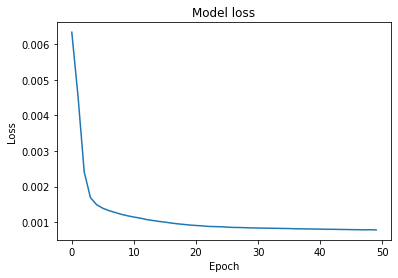

In [75]:
im_conv_model.save('im_conv_model.h5')
plot_loss(hist4)

In [76]:
out4 = im_conv_model.predict(conv_full_data)
out4[:,0] = abs(out4[:,0])
print(np.max(out4[:,0]), np.min(out4[:,0]))

0.41038004 0.04837583


**Predicted cluster**

In [77]:
im_conv_pred_cluster, im_conv_pred_label = gen_cluster(out4[:,0])
print(len(ori_cluster[0]), len(ori_cluster[1]), len(ori_cluster[2]), len(ori_cluster[3]))
print(len(im_conv_pred_cluster[0]), len(im_conv_pred_cluster[1]), len(im_conv_pred_cluster[2]), len(im_conv_pred_cluster[3]))

1882273 371016 129985 55066
2438340 0 0 0


**Performance of model**

In [78]:
conf_mat4 = gen_conf_mat(ori_label, im_conv_pred_label)
print(conf_mat4)
print("Accuracy of model =", find_accuarcy(conf_mat4))

[[1882273.       0.       0.       0.]
 [ 371016.       0.       0.       0.]
 [ 129985.       0.       0.       0.]
 [  55066.       0.       0.       0.]]
Accuracy of model = 77.19485387599761
